# 기계학습 (60점)

### 커머스 앱데이터
dataurl =https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_m1.csv

데이터는 커머스 앱의 유저 로그에 관한 데이터이다.      
timestamp : event 발생시각    
event : 로그의 이벤트 명
- first_visit : 첫방문, 첫 방문시에는 구매를 하지 않는다
- visit : 앱방문
- visit_and_purchase : 앱방문 및 제품 구매     

params : 이벤트 상세
- source : 첫방문 유입 소스를 의미한다. search : 단순 검색 / promotion : 마케팅 / sns : sns유입
- product : 구매 제품   

age: 유저 나이    
gender : 유저 성별

In [1]:
import pandas as pd
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_m1.csv')
df.head()

,user_id,timestamp,event,params,age,gender
0,668300627f964509a7f5b5f63b570d55,2024-02-18,first_visit,{'source': 'sns'},31,M
1,668300627f964509a7f5b5f63b570d55,2024-03-04,visit,NaN,31,M
2,668300627f964509a7f5b5f63b570d55,2024-03-16,visit,NaN,31,M
3,668300627f964509a7f5b5f63b570d55,2024-03-30,visit,NaN,31,M
4,668300627f964509a7f5b5f63b570d55,2024-04-26,visit_and_purchase,{'product': 'Clothing'},31,M


### 기계학습1
시각화를 포함한 데이터 EDA

In [2]:
def resume(df):
    print(df.shape)
    tmp = pd.DataFrame()
    tmp['dtypes'] = df.dtypes
    tmp['고유값'] = df.nunique()
    tmp['결측치'] =df.isna().sum()
    tmp['첫번째값'] = df.iloc[0,:]
    tmp['두번째값'] = df.iloc[1,:]   
    return tmp
resume(df)

(68175, 6)


,dtypes,고유값,결측치,첫번째값,두번째값
user_id,object,7431,0,668300627f964509a7f5b5f63b570d55,668300627f964509a7f5b5f63b570d55
timestamp,object,366,0,2024-02-18,2024-03-04
event,object,3,0,first_visit,visit
params,object,13,36113,{'source': 'sns'},NaN
age,int64,41,0,31,31
gender,object,2,0,M,M


- 6개 특성, 68175개의 샘플을 가진 데이터임
- 고유값으로 user_id, 이벤트, 시간, 나이, 성별을 가진 데이터이다. 
- param은 절반정도가 결측치로 삭제하지 않고 하나의 범주로 남기는 것이 나음
- event는 첫방문, 방문, 방문및구매로 구분

### 기계학습2
유저의 7일차 31일차 앱 재방문율(리텐션)을 구하라.  

(추가설명)   
리텐션은 최초 앱방문일자를 기준으로 몇일 차 후에 또다시 방문했는지를    
전체 유저에 대해 데이터를 구하고 0일차 방문 횟수로 나누어 비율을 구한 값이다.   
- 아래와 같이 전체 일자에 대한 리텐션 결과를 구할 수 있다 <br>
![img](https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_m2_img.png) 
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>retention-proportion</th>
    </tr>
    <tr>
      <th>day</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>100.000000</td>
    </tr>
    <tr>
      <th>1</th>
      <td>69.519580</td>
    </tr>
    <tr>
      <th>2</th>
      <td>1.264971</td>
    </tr>
    <tr>
      <th>3</th>
      <td>1.251514</td>
    </tr>
    <tr>
      <th>4</th>
      <td>1.318800</td>
    </tr>
  </tbody>
</table>

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
first_visits = df[df['event'] == 'first_visit'].groupby('user_id').agg({'timestamp':'min'}).reset_index()
second_visits =  df[df['event'] == 'visit'].groupby('user_id').agg({'timestamp':'min'}).reset_index()
retention = pd.merge(first_visits,second_visits, on = 'user_id')

retention['retentionDays'] = retention['timestamp_y']-retention['timestamp_x']
retentionDays = retention['retentionDays'].dt.days
retention = retention.groupby('retentionDays').agg({'user_id':'size'})/first_visits['user_id'].nunique()
(retention.loc[['7 days','31 days']]*100)

,user_id
retentionDays,
7 days,0.605571
31 days,0.780514


### 기계학습3     
가입 후 한달동안의 유저 행동을 통해 다음달 첫주 동안의 물건 구매 여부를 확인하는 모델링을 진행하려고 한다.     
이를 위한 전처리를 진행하라. 
- 유저별 가입 후 한달 동안의 메타정보에 대한 테이블 (자율구성)    
- 종속 변수 : 가입 후 한달 후 일주일 동안 물건 구매 여부 (0,1)

In [4]:
# 가입 후 한달 이 언제임
def param_clean(x):
    x = x.replace('{','').replace('}','').replace("'","").split(':')[1]
    return x
df['limited_day'] = (df.loc[df['event']=='first_visit','timestamp'] +pd.Timedelta(30,'d'))
df['limited_day'] = df['limited_day'].ffill()
df['target'] = 0
df.loc[((df['timestamp'] < df['limited_day']) & (df['event']=='visit_and_purchase')) ,'target']=1
res = df.loc[(df['event']=='visit_and_purchase')] # 종속변수 테이블 res 구성
res = res[['user_id','params','age','gender','target']]
res['product'] = res['params'].apply(param_clean)
res = res[['user_id','product','age','gender','target']]

### 기계학습4     
2개의 분류 모델을 통해 학습을 진행하고 모델 평가를 진행하라    
유의미한 변수를 추출하라

In [5]:
res0 = df.loc[(df['event']=='first_visit'),['user_id','params']]
res0['params'] = res0['params'].apply(param_clean)
res0.columns = ['user_id', 'source']

In [6]:
res1 = df.groupby('user_id').agg({'timestamp':['min','max']}).reset_index()
res1.columns = ['user_id','min','max']
res1['leadtime'] =(res1['max']-res1['min']).dt.days
res1 = res1[['user_id', 'leadtime']]

In [7]:
res2 = df.groupby('user_id').agg({'event':'count'}).reset_index() # 방문횟수수
res2.columns = ['user_id', 'visit_no']

In [8]:
res_f = res.merge(res0,on='user_id').merge(res1,on='user_id').merge(res2,on='user_id')
res_f=res_f[['product', 'age', 'gender', 'source', 'leadtime','visit_no', 'target']]
res_f = pd.get_dummies(res_f,drop_first=False,dtype=int)
res_f

,age,leadtime,visit_no,target,product_ Beauty Products,product_ Books,product_ Clothing,product_ Electronics,product_ Groceries,product_ Home & Kitchen,product_ Movies & TV,product_ Music,product_ Sports,product_ Toys,gender_F,gender_M,source_ promotion,source_ search,source_ sns
0,31,302,14,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1,31,302,14,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
2,31,302,14,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
3,31,302,14,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
4,31,302,14,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24626,27,253,7,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
24627,27,253,7,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
24628,27,253,7,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
24629,27,253,7,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

X = res_f.drop('target',axis=1)
y = res_f['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

xgb, rfc = XGBClassifier(), RandomForestClassifier()
models = [xgb, rfc]
m_names = ['XGBClassifier','RandomForestClassifier']
for idx, model in enumerate(models):
    s= datetime.now()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    e= datetime.now()
    t= e-s
    print(f'===={m_names[idx]}====')
    # print(f'소요시간 : {t:.2f}sec')          
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test,y_test))
    display(pd.DataFrame(model.feature_importances_, index=X.columns,columns=['importance']).sort_values('importance',ascending=False)[:5])
    print()    


====XGBClassifier====
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      6132
           1       0.55      0.09      0.15      1258

    accuracy                           0.83      7390
   macro avg       0.70      0.54      0.53      7390
weighted avg       0.79      0.83      0.78      7390

[[6132    0]
 [   0 1258]]


,importance
leadtime,0.106412
product_ Beauty Products,0.069605
source_ sns,0.067159
product_ Toys,0.066382
product_ Groceries,0.060550



====RandomForestClassifier====
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      6132
           1       0.32      0.13      0.18      1258

    accuracy                           0.80      7390
   macro avg       0.58      0.54      0.54      7390
weighted avg       0.75      0.80      0.77      7390

[[6132    0]
 [   0 1258]]


,importance
leadtime,0.406413
age,0.269882
visit_no,0.182627
product_ Groceries,0.010992
product_ Music,0.010888


- xgboost와 ensenble 모델을 사용하여 비교하였다.
- 두 모델 모두 f1스코어 성능이 0.8 이상으로 양호한 성능을 보였다.
- 특히 Confusion Matrix확인결과, 테스트데이터 7390개에 대해 전부 맞추는 것을 확인하였다.
- 중요 변수의 경우에는 두 모델 모두 첫방문부터 구매까지 걸리는 시간이 중요한 변수로 작용하였다.
- ensenble 모델에서는 age와 방문횟수(visit_no) 가 주요한 변수인 반면, xgboost에서는 보다 변수 중요도가 고르게 분포하며, 
- 특히 상품 중 Clothing, Musics, Toys, Books 등의 구매가 주요하게 영향을 미쳤다.

### 기계학습5     
모델 성능 개선을 위해 추가로 필요한 데이터를 개발팀에 요청하려한다.   
필요항목과 해당 항목을 요청하는 이유를 서술하라     

- 단가 정보가 필요하다. 가격 정보도 구매 탄력성에 결정적 역할을 할 것으로 예상된다.
- 구매 후 재구매 여부도 필요하다. 초기 리텐션이 아닌 지속적인 리텐션의 재발생이 플랫폼 성패에 중요한 요인이 된다.
- 사용 만족도, 기대감에 대한 조사데이터도 있다면 만족도에 따른 구매영향도를 파악할 수 있다.

### 비트코인 가격 데이터   
dataurl =https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_m2.csv

데이터는 특정기간 동안의 1분봉 비트코인 가격 데이터이다    
TIMESTAMP : timestamp
bitcoin($) : 비트코인가격(달러)


In [22]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_m2.csv')
df.head()

,TIMESTAMP,bitcoin($)
0,1.577837e+09,7195.24
1,1.577837e+09,7187.67
2,1.577837e+09,7184.41
3,1.577837e+09,7183.83
4,1.577837e+09,7185.54


In [23]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], unit = 's')

### 기계학습5    
결측치 대치 방법에 대해 논의하고 적절한 방법으로 주어진 데이터의 결측치를 처리하라       

비트코인가격은 전일자가격을 가져오고, timestamp는 보간

In [14]:
df['bitcoin($)'] = df['bitcoin($)'].ffill()

In [15]:
df['TIMESTAMP'] = df['TIMESTAMP'].interpolate()

### 기계학습6     
데interpolate통계적, 시각적 방법을 통해 확인하라.     

<Axes: xlabel='TIMESTAMP'>

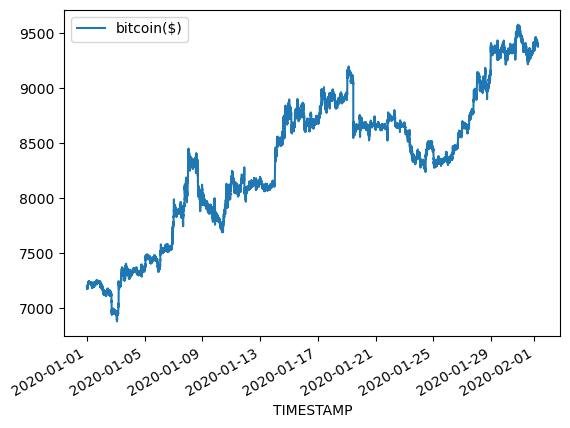

In [25]:
df_ = df.set_index('TIMESTAMP')
df_.plot()

### 기계학습7     
ARIMA 모델을 통해 모델링을 진행하고 평가하라. (p,d,q) 파라미터의 적정값을 선정한 이유를 서술하라   
(2020년 2월 6시간 동안의 데이터를 평가용 데이터로 한다)

원본의 pvalue :0.7759466406663312
차분1의 pvalue :0.0


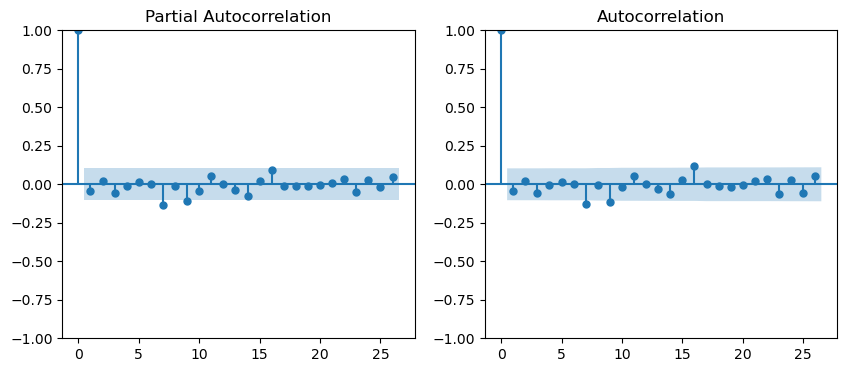

In [51]:
res = df[df['TIMESTAMP'].dt.month ==2]
res = res.set_index('TIMESTAMP')
from statsmodels.tsa.stattools import adfuller
adf = adfuller(res,regression='ct')
print(f'원본의 pvalue :{adf[1]}')
adf1 = adfuller(res.diff(1).dropna(),regression='ct')
print(f'차분1의 pvalue :{adf1[1]}')

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(10,4))
plot_pacf(res.diff(1).dropna(), ax=ax[0])
plot_acf(res.diff(1).dropna(), ax=ax[1])
plt.show()

- 1을 차분한 데이터에서 정상성을 만족하므로 d는 1
- 부분 자기상관 그래프그래프에서 p는 1로 자기상관 그래프에서 q는 1로 설정할 때가 상관관계가 유의미하게 나타났다
- 따라서 선정한 p,d,q는 1,1,1이다. auto-arima를 통해 자동으로 설정한 p, d, q 와 비교해보자

In [57]:
from pmdarima import auto_arima
auto_model = auto_arima(res,seasonal=True)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  360
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1074.280
Date:                Thu, 25 Apr 2024   AIC                           2150.561
Time:                        10:48:35   BIC                           2154.444
Sample:                    02-01-2020   HQIC                          2152.105
                         - 02-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        23.2655      1.354     17.186      0.000      20.612      25.919
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):                24.93
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- AutoArima에서는 p,d,q룰 0,1,0으로 하였으며,
- 수동으로 p,d,q 1,1,1로 설정한 모델이 미세하게 우수한 점수를 보인다

In [65]:
from statsmodels.tsa.arima.model import ARIMA
p, d, q = 1, 1, 1
P, D, Q, m = 1, 1, 1, 12
model = ARIMA(res, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()
print(model.summary())

                                    SARIMAX Results                                     
Dep. Variable:                       bitcoin($)   No. Observations:                  360
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1060.694
Date:                          Thu, 25 Apr 2024   AIC                           2131.388
Time:                                  11:01:51   BIC                           2150.635
Sample:                              02-01-2020   HQIC                          2139.052
                                   - 02-01-2020                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9509      0.075    -12.667      0.000      -1.098      -0.804
ma.L1          0.9202      0.091     10.153      0.

```
SARIMAX(Seasonal AutoRegressive Integrated Moving Average with External Regressors) 모델의 결과를 보여줍니다. 비트코인 가격 데이터를 사용하여 시계열 분석을 수행한 결과입니다.


주요 내용은 다음과 같습니다:



모델 정보: ARIMA(1,1,1) 모델을 사용했으며, 360개의 관측치를 사용했습니다.


모수 추정치: AR(1) 계수는 -0.993, MA(1) 계수는 0.9996, 분산은 23.1814입니다. 이 계수들은 모두 통계적으로 유의합니다.


모델 적합도 검정: Ljung-Box 통계량은 0.73으로 잔차가 백색잡음(white noise)임을 보여줍니다. 하지만 Jarque-Bera 통계량은 0.00으로 잔차가 정규분포를 따르지 않음을 나타냅니다.


경고 메시지: 공분산 행렬 계산 시 복잡한 단계 방법을 사용했음을 알려줍니다.



요약하면 이 ARIMA 모델은 비트코인 가격 데이터를 잘 적합하지만, 잔차의 정규성 가정을 만족시키지 못합니다. 모델 개선이 필요할 수 있습니다.
```

# 통계 (40점)

### 통계1      
자동차 A,B,C에 대해 유저 9명의 선호도(1~6, 6은 가장선호,1은 가장 비선호)를 표시했다.    
자동차 간의 선호도 차이가 존재하는지 검정하라     

<table>
<tr>
    <th></th>
    <td>차량 A</td>
    <td>차량 B</td> 
    <td>차량 C</td>  
</tr>

<tr>
    <td>피험자1</td> 
    <td>4</td> 
    <td>1</td>
    <td>6</td>
</tr>
<tr>
    <td>피험자2</td> 
    <td>3</td> 
    <td>4</td>
    <td>6</td>
</tr>
<tr>
    <td>피험자3</td> 
    <td>2</td> 
    <td>4</td>
    <td>6</td>
</tr>
    <tr>
    <td>피험자4</td> 
    <td>4</td> 
    <td>3</td>
    <td>2</td>
</tr>
    <tr>
    <td>피험자5</td> 
    <td>4</td> 
    <td>1</td>
    <td>6</td>
</tr>
    <tr>
    <td>피험자6</td> 
    <td>6</td> 
    <td>4</td>
    <td>2</td>
</tr>
    <tr>
    <td>피험자7</td> 
    <td>5</td> 
    <td>3</td>
    <td>5</td>
</tr>
    <tr>
    <td>피험자8</td> 
    <td>6</td> 
    <td>3</td>
    <td>2</td>
</tr>
    <tr>
    <td>피험자9</td> 
    <td>2</td> 
    <td>4</td>
    <td>6</td>
</tr>
</table>  

(1) 가설설정     
(2) 검정 통계량 확인 및 가설검정

```
H0:피실험자간 차량선호도는 차이가 없다
H1:피실험자간 차량선호도 차이가 있다
```

In [ ]:
import numpy as np
from scipy.stats import friedmanchisquare

data = np.array([[4, 1, 6],
                 [3, 4, 6],
                 [2, 4, 6],
                 [4, 3, 2],
                 [4, 1, 6],
                 [6, 4, 2],
                 [5, 3, 5],
                 [6, 3, 2],
                 [2, 4, 6]])

Q_r, p_val = friedmanchisquare(*data.T)
print(f"프리드만 검정 통계량: Q_r = {Q_r:.4f}")
print(f"p-value: {p_val:.4f}")

- 결론 : 귀무가설을 기각하지 못하므로 피실험자 간 차량선호도의 차이가 없다

### 통계2
dataurl = https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_s2.csv
위 데이터는 영화관 이용객의 장르별 팝콘 구매여부에 관한 데이터이다.    
장르별 팝콘 구매 여부가 연관이 있는지 확인하고 싶다.    
(1) 가설설정, 가설 검증      
(2) 장르과 구매여부의 정량적인 상관정도를 구하고 분석하라    

In [ ]:
import pandas as pd
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_s2.csv')
df.head()

In [ ]:
'''
장르와 구매여부의 정량적인 상관관계를 구하기 위해 카이제곱 독립성검정을 진행한다.
이를 위해 교차표를 만든다
'''
H0 = '장르과 구매여부는 상관이 없이 서로 독립적이다.'
H1 = '장르과 구매여부는 상관관계가 있다.'

df_c =  pd.pivot_table(index='장르',columns='구매여부', aggfunc='count', data =df)
df_c.columns = ['구매','미구매']

from scipy.stats import chi2_contingency
stats, p_val, dof, exp = chi2_contingency(df_c)
print(f'카이제곱 검정통계량은 {stats:.3f}, p-value는 {p_val:.3f} 이므로')
if p_val<0.05:print(H1)
else : print(H0)


### 통계 3     
어느 도시에서 성인 전체의 25%가 흡연자라고 한다. 만약 현재도 이와 비슷한 비율이 유지된다면 1300명의 성인표본에서 흡연자가 317명보다 작을 확률은 얼마인가?

In [ ]:
'''
담배를 피는 것은 이항확률분포임. 흡연율이 주어져 있으므로, 이항확률분포에서의 누적확률을 사용하여 문제를 푼다
'''
p = 0.25
n = 1300
x = 317
from scipy.stats import binom
binom.cdf(x,n,p)

### 통계 4     
어떤 앱 개발 회사가 새로운 게임을 출시했다. 사용자가 게임 내에서 특정 퀘스트를 클리어하는 성공 확률이 0.3이라고 한다.    
(1) 사용자가 총 3회의 성공을 하기까지 시도한 횟수가 5회 미만일 확률은 얼마인가?         
(2) 사용자가 4번의 퀘스트 클리어 성공을 경험하기까지 평균적으로 몇 번의 시도를 하는가?    

In [ ]:
'''
사용자가 총 3회의 성공을 하기까지 시도한 횟수가 5회 미만일 확률은 얼마인가?
이항분포로 정리
'''
from scipy.stats import binom, geom
x, n, p = 3, 5, 0.3
binom.pmf(x, n, p)

In [ ]:
'''
사용자가 4번의 퀘스트 클리어 성공을 경험하기까지 평균적으로 몇 번의 시도를 하는가?
기하분포로 정리
'''
x,p= 4, 0.3
round(geom.mean(p,x),0)

### 통계5    
데이터는 년도별 플로리다에서 발생한 상어 공격 횟수와 해당 연도의 인구수이다. 
일반화선형모형을 이용하여 년도별 인구에 따른 상어공격 수에 대한 모델링을 진행하라
(포아송 분포를 고려하여 모델링을 하고 오프셋은 인구를 1000으로 나눈 후 로그를 씌운값으로 진행하라.)   
(1) 모델링 후 모델에 대한 분석을 진행하라.(시각화포함)     
(2) 2000년도에 인구가 16224544라고 할 때 상어 공격횟수를 예측한 값을 출력하라    

In [ ]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_s5.csv')
df.head()

In [ ]:
df.info()

In [ ]:
def pre(x):
    return np.log1p(x/1000)
df['Population'] = df['Population'].apply(pre)
df

In [ ]:
df.describe()

In [ ]:
from pandas_profiling import ProfileReport
ProfileReport(df)

In [ ]:
import statsmodels.formula.api as smf

# 로지스틱 회귀분석 수행
logit_model = smf.ols('Attacks ~ Population', data=df).fit()

# 결과 출력
print(logit_model.summary())

```
이 출력은 OLS(Ordinary Least Squares, 최소제곱법) 회귀분석 결과를 보여줍니다. 주요 내용은 다음과 같습니다.



종속변수는 Attacks이고, 독립변수는 Population입니다.
결정계수(R-squared)는 0.500으로, 독립변수 Population이 종속변수 Attacks의 분산 중 50%를 설명합니다.
F-통계량은 51.95이고, 유의확률(Prob (F-statistic))은 2.31e-09로 매우 작습니다. 이는 회귀모델이 통계적으로 유의미함을 의미합니다.
회귀계수(coef) 열에서 Intercept는 -77.7381, Population은 9.5438입니다. 이는 회귀식 Attacks = -77.7381 + 9.5438 * Population을 의미합니다.
표준오차(std err), t-통계량(t), 유의확률(P>|t|), 신뢰구간(0.025, 0.975)도 제공됩니다.
잔차(residuals)의 정규성 검정 결과인 Omnibus 통계량의 유의확률(Prob(Omnibus))이 0.002로 작아 잔차가 정규분포를 따르지 않음을 시사합니다.
Jarque-Bera 통계량의 유의확률(Prob(JB))도 0.00128로 작아 잔차가 정규분포를 따르지 않음을 시사합니다.
Durbin-Watson 통계량은 1.159로 자기상관이 있을 수 있습니다.

전반적으로 회귀모델은 유의미하지만, 잔차의 정규성 가정과 자기상관 가정을 만족하지 않아 모델 개선이 필요할 수 있습니다.
```

In [ ]:
'''
(2) 2000년도에 인구가 16224544라고 할 때 상어 공격횟수를 예측한 값을 출력하라
'''
-77.7381 + 9.5438 * pre(16224544)